In [1]:
import math
import re
import time
from datetime import datetime, date

import requests
from bs4 import BeautifulSoup
from selenium import webdriver

from IPython.display import Image
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

from pykrx import stock
import FinanceDataReader as fdr
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import FinanceDataReader as fdr
import finterstellar as fs


import talib.abstract as ta
from talib import MA_Type


import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

pd.set_option('max_colwidth', None)
plt.rcParams['font.family']

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


['Malgun Gothic']


<pre>
RSI(70,30)  or  스토캐스틱(80,20)
MACD  or  볼린저밴드
MACD를 이용한 골크데크

삼성전자 2022년
1년치 기준
초기자금 백만원

# 삼성전자 데이터 로드

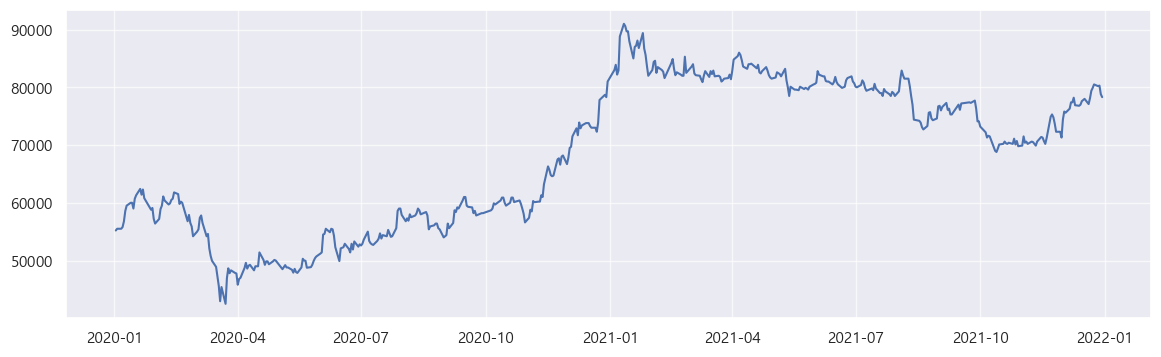

In [2]:
삼성2020 = stock.get_market_ohlcv('20200101', '20210101', '005930')[['시가', '고가', '저가', '종가']]
삼성2021 = stock.get_market_ohlcv('20210101', '20220101', '005930')[['시가', '고가', '저가', '종가']]
df = pd.concat([삼성2020, 삼성2021], axis=0)

plt.figure(figsize=(14,4))
plt.plot(df['종가'])
plt.show()

# MACD
- Moving Average Convergence Divergence
- MACD: 단기이평(12) - 장기이평(26)
- signal: 9일 평균

- hist: 음수 -> 양수 (매수신호)

- hist: 양수 -> 음수 (매도신호)

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


2020-02-20 00:00:00


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


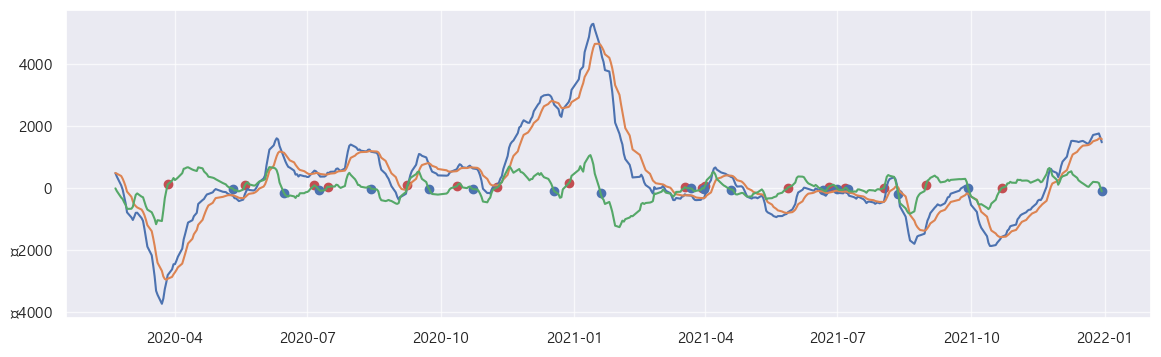

In [3]:
MACD = ta.MACD(df['종가'], fastperiod=12, slowperiod=26, signalperiod=9)
MACD = np.array(MACD).T
MACD = pd.DataFrame(MACD, columns=['MACD', 'signal', 'hist'], index=df.index)
MACD = MACD.dropna()
print(MACD.index[0])

골든크로스 = MACD[MACD['hist'].shift()*MACD['hist']<0]
매수신호 = 골든크로스[골든크로스['hist']>0]
매도신호 = 골든크로스[골든크로스['hist']<0]

plt.figure(figsize=(14,4))
plt.plot(MACD[['MACD', 'signal', 'hist']])
plt.scatter(매수신호.index, 매수신호['hist'], color='r')
plt.scatter(매도신호.index, 매도신호['hist'], color='b')
plt.show()

# 스토캐스틱(N-n-t) / 5-3-3
- 80이상이면 과매수구간: 매도신호
- 20이하면 과매도구간: 매수신호

2020-01-14 00:00:00


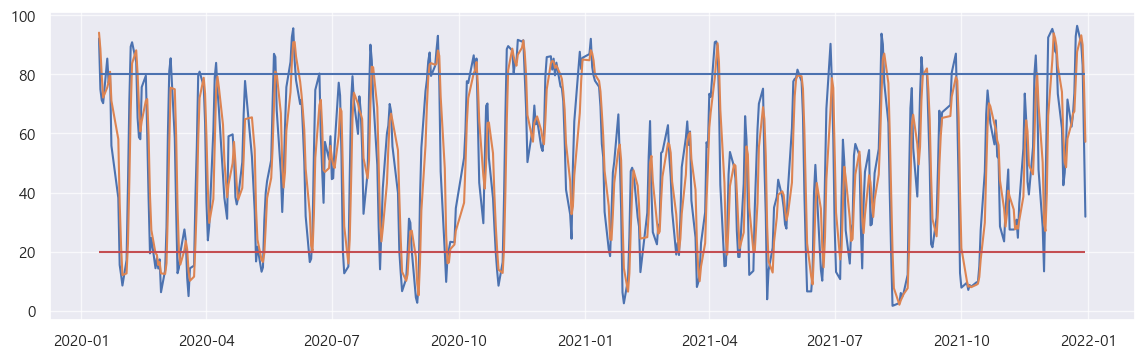

In [4]:
STOCH = ta.STOCH(df['고가'], df['저가'], df['종가'], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
STOCH = np.array(STOCH).T
STOCH = pd.DataFrame(STOCH, columns=['slowK', 'slowD'], index=df.index)
STOCH = STOCH.dropna()
print(STOCH.index[0])

plt.figure(figsize=(14,4))
plt.plot(STOCH)
plt.hlines(80, STOCH.index[0], STOCH.index[-1], color='b')
plt.hlines(20, STOCH.index[0], STOCH.index[-1], color='r')
plt.show()

2020-01-10 00:00:00


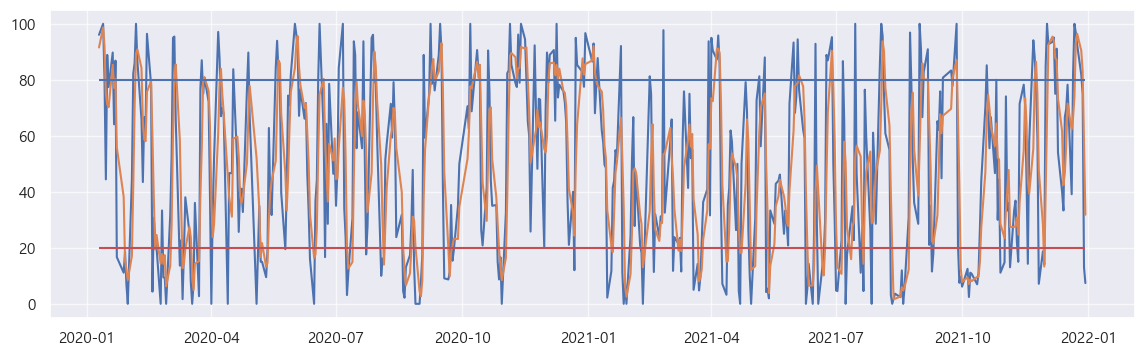

In [5]:
STOCHF = ta.STOCHF(df['고가'], df['저가'], df['종가'], fastk_period=5, fastd_period=3, fastd_matype=0)
STOCHF = np.array(STOCHF).T
STOCHF = pd.DataFrame(STOCHF, columns=['fastK', 'fastD'], index=df.index)
STOCHF = STOCHF.dropna()
print(STOCHF.index[0])

plt.figure(figsize=(14,4))
plt.plot(STOCHF)
plt.hlines(80, STOCHF.index[0], STOCHF.index[-1], color='b')
plt.hlines(20, STOCHF.index[0], STOCHF.index[-1], color='r')
plt.show()

In [6]:
# (리스트)교집합(리스트)
매수인덱스 = list(set(매수신호.index).intersection(set((STOCHF['fastK']<=20).index)))
매도인덱스 = list(set(매도신호.index).intersection(set((STOCHF['fastK']>=80).index)))

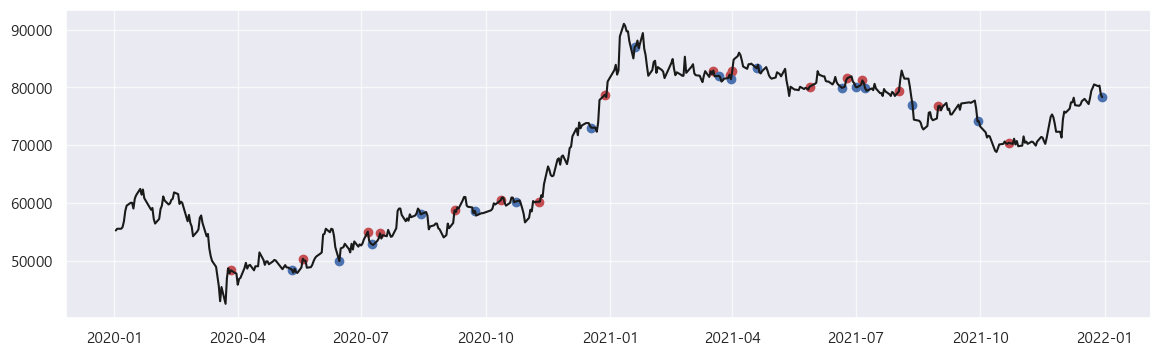

In [7]:
alldata = pd.concat([df, MACD, STOCH, STOCHF], axis=1).dropna()
alldata['신호'] = 0
alldata.loc[매수인덱스, '신호'] = 1
alldata.loc[매도인덱스, '신호'] = -1
plt.figure(figsize=(14,4))
plt.plot(df['종가'], color='k')
plt.scatter(alldata[alldata['신호']==1].index, alldata[alldata['신호']==1]['종가'], color='r')
plt.scatter(alldata[alldata['신호']==-1].index, alldata[alldata['신호']==-1]['종가'], color='b')
plt.show()

- 빨강: 매수신호
- 파랑: 매도신호

# 백테스팅

## 데이터프레임으로 구현

In [8]:
현자산 = 1000000
현주식수 = 0
현자산_list = []
현주식수_list = []

for idx in alldata.index:
    if alldata.at[idx, '신호']==1: # 매수
        현주식수 += 현자산//alldata.at[idx,'종가']
        현자산 = 현자산%alldata.at[idx,'종가']
        print(idx, '매수!!', 현주식수, '\t',  현자산)
        
    elif alldata.at[idx, '신호']==-1: # 매도
        현자산 += 현주식수*alldata.at[idx,'종가']
        현주식수 = 0
        print(idx, '매도!!', 현주식수, '\t',  현자산)
        
    현자산_list.append(현자산)
    현주식수_list.append(현주식수)
        
        
alldata['자산'] = 현자산_list
alldata['현주식수'] = 현주식수_list
alldata

2020-03-27 00:00:00 매수!! 20 	 34000
2020-05-11 00:00:00 매도!! 0 	 1002000
2020-05-19 00:00:00 매수!! 19 	 46300
2020-06-15 00:00:00 매도!! 0 	 994400
2020-07-06 00:00:00 매수!! 18 	 4400
2020-07-09 00:00:00 매도!! 0 	 954800
2020-07-15 00:00:00 매수!! 17 	 24900
2020-08-14 00:00:00 매도!! 0 	 1010900
2020-09-08 00:00:00 매수!! 17 	 13000
2020-09-23 00:00:00 매도!! 0 	 1009200
2020-10-12 00:00:00 매수!! 16 	 42800
2020-10-23 00:00:00 매도!! 0 	 1006000
2020-11-09 00:00:00 매수!! 16 	 42800
2020-12-18 00:00:00 매도!! 0 	 1210800
2020-12-28 00:00:00 매수!! 15 	 30300
2021-01-19 00:00:00 매도!! 0 	 1335300
2021-03-18 00:00:00 매수!! 16 	 8900
2021-03-22 00:00:00 매도!! 0 	 1320900
2021-03-30 00:00:00 매수!! 16 	 5700
2021-03-31 00:00:00 매도!! 0 	 1308100
2021-04-01 00:00:00 매수!! 15 	 64600
2021-04-19 00:00:00 매도!! 0 	 1314100
2021-05-28 00:00:00 매수!! 16 	 32500
2021-06-21 00:00:00 매도!! 0 	 1310900
2021-06-25 00:00:00 매수!! 16 	 5300
2021-07-01 00:00:00 매도!! 0 	 1286900
2021-07-06 00:00:00 매수!! 15 	 68900
2021-07-08 00:00:00 매

,시가,고가,저가,종가,MACD,signal,hist,slowK,slowD,fastK,fastD,신호,자산,현주식수
날짜,,,,,,,,,,,,,,
2020-02-20,60700,61300,59600,60000,485.048744,491.014132,-5.965388,19.397993,38.956575,23.076923,19.397993,0,1000000,0
2020-02-21,58800,59800,58500,59200,371.931035,467.197513,-95.266478,24.615385,27.268673,20.000000,24.615385,0,1000000,0
2020-02-24,57400,58100,56800,56800,87.614527,391.280916,-303.666388,14.358974,19.457451,0.000000,14.358974,0,1000000,0
2020-02-25,56200,58000,56200,57900,-48.389739,303.346785,-351.736524,17.777778,18.917379,33.333333,17.777778,0,1000000,0
2020-02-26,56000,57000,56000,56500,-266.075251,189.462378,-455.537628,14.255765,15.464172,9.433962,14.255765,0,1000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,80200,80800,80200,80500,1714.733795,1510.993525,203.740270,96.458333,87.668533,92.500000,96.458333,0,64900,16
2021-12-27,80600,80600,79800,80200,1749.568900,1558.708600,190.860300,90.397727,93.251263,81.818182,90.397727,0,64900,16
2021-12-28,80200,80400,79700,80300,1764.900463,1599.946973,164.953490,83.106061,89.987374,75.000000,83.106061,0,64900,16


## 클래스로 구현

In [9]:
class BackTesting:
    def __init__(self, alldata, start_cash) :
        self.현자산 = start_cash
        self.현주식수 = 0
        self.총수익 = 0
        self.현자산_list = []
        self.현주식수_list = []

    def stock(self) :
        for idx in alldata.index:
            if alldata.at[idx, '신호']==1: # 매수
                self.현주식수 += self.현자산//alldata.at[idx,'종가']
                self.현자산 = self.현자산%alldata.at[idx,'종가']
                # print(idx, '매수!!', self.현주식수, '\t',  self.현자산)

            elif alldata.at[idx, '신호']==-1: # 매도
                self.현자산 += self.현주식수*alldata.at[idx,'종가']
                self.현주식수 = 0
                # print(idx, '매도!!', self.현주식수, '\t',  self.현자산)

            현자산_list.append(self.현자산)
            현주식수_list.append(self.현주식수)
        self.총수익 = 현자산_list[-1]
        return self.총수익
            
SEED = 10000000000000000000

# for SEED in range(1000000, 10000000, 1000000):
backtest = BackTesting(alldata, SEED)
총수익 = backtest.stock()
print( 총수익 )
print((총수익 - SEED)/SEED * 100, '%')


1.3354015738263806e+19
33.54015738263806 %


- 이동평균선 조절하면서 매도구간 매수구간 보면서 잘 조절하면 더 좋은 결과 나올듯 ㅎ_ㅎ